# Capstone 1: EDA- Data Storytelling

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from scipy.stats import stats

In [2]:
infile = open('gamelogs09_18','rb')
gamelogs = pickle.load(infile)
infile.close()

In [3]:
def melt_gamelogs(other_id_vars):
    """Function to melt gamelogs so can perform calculation for each team"""
    melted = pd.melt(gamelogs, id_vars= ['Date','HomeWin','DoubleHeader'] + other_id_vars, value_vars = ['HomeTeam','VisitingTeam'], value_name = 'Team')
    melted = melted.sort_values('Team')
    return melted

def merge_twice(df1, df2, df1_home, df1_visit, df2col):
    """Function to merge df twice-once for info about home team, then for info about away team"""
    merged = pd.merge(df1,df2, left_on = ['Date', 'DoubleHeader',df1_home], right_on = ['Date','DoubleHeader', df2col])
    merged = pd.merge(merged,df2, left_on = ['Date', 'DoubleHeader',df1_visit], right_on = ['Date', 'DoubleHeader',df2col], suffixes = ['_H','_V'])
    return merged

## Question 1: Does the home team win more often than the visiting team?

In [4]:
#since there is only one tie we will count it as a loss for the home team
def game_winner(game):
    """Function to indicate whether the home team won (1) or lost (0)"""
    if game['HomeRunsScore'] > game['VisitorRunsScored']: #home team win
        homewin = 1   
    else:
        homewin = 0
    return homewin

In [5]:
gamelogs['HomeWin'] = gamelogs.apply(lambda game: game_winner(game), axis = 1)

([<matplotlib.patches.Wedge at 0x1a1e7d42e8>,
 [Text(-0.12841897196065966, 1.0924781771919143, 'Home Team Wins'),
  Text(0.12841897196065952, -1.0924781771919143, 'Road Team Wins')],
 [Text(-0.07004671197854162, 0.5958971875592259, '53.7%'),
  Text(0.07004671197854154, -0.5958971875592259, '46.3%')])

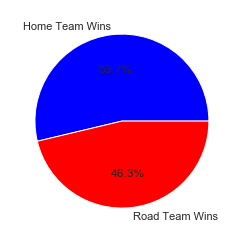

In [6]:
sns.set()
values = [sum(gamelogs['HomeWin']), len(gamelogs[gamelogs['HomeWin']==0])]
plt.pie(values, colors = ['blue', 'red'], labels = ['Home Team Wins','Road Team Wins'], autopct='%1.1f%%')

We see that in he 2009-2018 season, the home team has won 53.7% of MLB games.

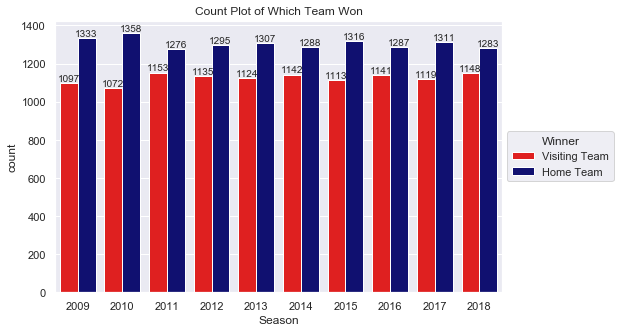

In [7]:
sns.set()
plt.figure(figsize=(8,5))
ax = sns.countplot(x = gamelogs['Date'].dt.year, hue='HomeWin', data = gamelogs, palette = ['red', 'navy'])
plt.xlabel('Season')
plt.title('Count Plot of Which Team Won')
#plt.xticks(np.arange(3), labels = ['Visiting Team','Tie','Home Team'])
plt.legend(title='Winner', loc='center left', labels=['Visiting Team','Home Team', 'Tie'], bbox_to_anchor = (1,0.5))
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    ax.annotate(p.get_height(), xy = (x.mean(), p.get_height()+10), ha='center', fontsize=10)


Breaking it down by year, we see that each season since 2009, the home teams have won more games than the visiting teams.

Let's also look at this as percent of games won by the home team in each year.

In [8]:
def percent_homewin(homewins_col):
    percent_wins = 100 * sum(homewins_col)/len(homewins_col)
    return percent_wins
def percent_roadwin(homewins_col):
    percent_wins = 100 * (1 - sum(homewins_col)/len(homewins_col))
    return percent_wins

In [9]:
by_year = gamelogs.groupby([gamelogs['Date'].dt.year])

percent_home_wins = by_year['HomeWin'].agg(percent_homewin)

(40, 60)

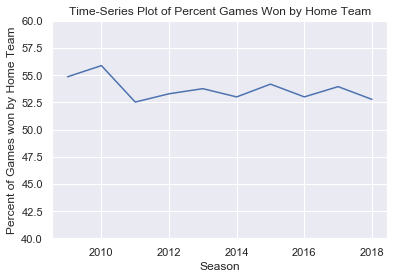

In [10]:
plt.plot(percent_home_wins)
plt.xlabel('Season')
plt.ylabel('Percent of Games won by Home Team')
plt.title('Time-Series Plot of Percent Games Won by Home Team')
plt.ylim([40,60])


### By team

In [11]:
by_hometeam = gamelogs.groupby(['HomeTeam'])
by_roadteam = gamelogs.groupby(['VisitingTeam'])

percent_home_wins = by_hometeam['HomeWin'].agg(percent_homewin)
percent_road_wins = by_roadteam['HomeWin'].agg(percent_roadwin)
percent_wins = pd.DataFrame({'percent_home_wins': percent_home_wins, 'percent_road_wins': percent_road_wins})
percent_wins['diff'] = percent_wins['percent_home_wins']-percent_wins['percent_road_wins']
percent_wins = percent_wins.sort_values('diff')

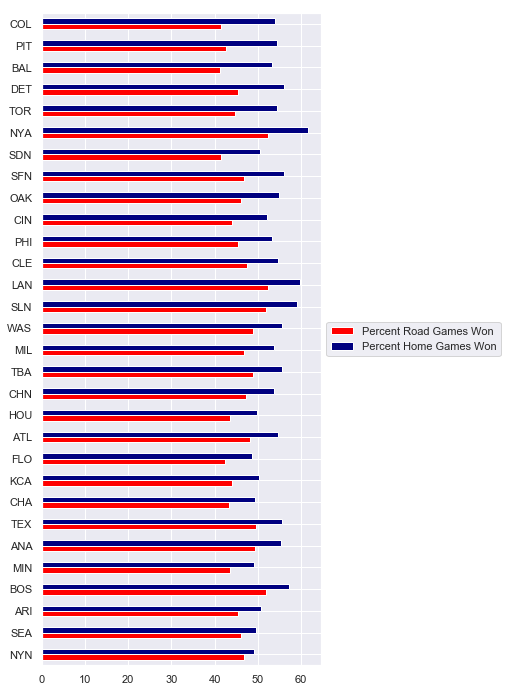

In [12]:
percent_wins.plot(y=['percent_road_wins', 'percent_home_wins'], kind='barh', color = ['red', 'navy'], figsize=(5,12))
plt.legend(loc='center left', labels=['Percent Road Games Won','Percent Home Games Won'], bbox_to_anchor = (1,0.5))

This barplot shows the percent of home games and the percent of road games that each team won in 2009-2018. We see that every team has won a higher percentage of games at home than on the road.  It is ordered from highest difference in win percentage at home and on the road to lowest.

In [13]:
by_hometeam_year = gamelogs.groupby(['HomeTeam', gamelogs['Date'].dt.year])
by_roadteam_year = gamelogs.groupby(['VisitingTeam', gamelogs['Date'].dt.year])

def away_wins(col):
    total = len(col) - sum(col)
    return total
    
total_home_wins = by_hometeam_year['HomeWin'].sum()
total_road_wins = by_roadteam_year['HomeWin'].agg(away_wins)
total_wins_year = pd.DataFrame({'num_home_wins': total_home_wins, 'num_road_wins': total_road_wins})
total_wins_year['total_num_wins'] = total_wins_year['num_home_wins'] + total_wins_year['num_road_wins']
total_wins_year.head()

num_home_wins  num_road_wins  total_num_wins
HomeTeam Date                                              
ANA      2009             49             48              97
         2010             43             37              80
         2011             45             41              86
         2012             46             43              89
         2013             39             39              78

In [14]:
total_wins_year.reset_index(inplace=True)
total_wins_melt = total_wins_year.melt(id_vars = ['HomeTeam', 'Date'], 
                        value_vars = ['num_home_wins', 'num_road_wins'], value_name = 'NumWins')
total_wins_melt.head()

,HomeTeam,Date,variable,NumWins
0,ANA,2009,num_home_wins,49
1,ANA,2010,num_home_wins,43
2,ANA,2011,num_home_wins,45
3,ANA,2012,num_home_wins,46
4,ANA,2013,num_home_wins,39


Text(0.5, 1.0, 'Box Plots of Number of Home and Road Wins for Each Team in the 2009-2018 Seasons')

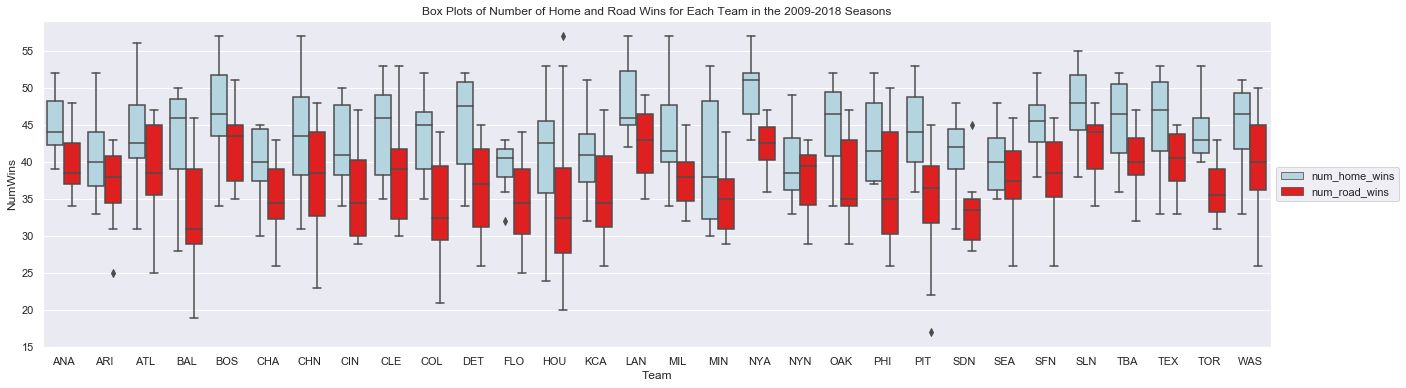

In [15]:
plt.figure(figsize=(22,6))
ax = sns.boxplot(x='HomeTeam', y='NumWins', hue='variable', data=total_wins_melt, palette=['lightblue', 'red'])
plt.legend(loc='center left', title=None, bbox_to_anchor = (1,0.5))
plt.xlabel('Team')
plt.title('Box Plots of Number of Home and Road Wins for Each Team in the 2009-2018 Seasons')

These boxplots suggest that each team does play better at home than on the road.  This seems to be particularly true of teams such as the Los Angeles Angels (ANA), and the New York Yankees (NYA), and San Diego Padres (SDN), and San Francisco Giants, whose box plots for home wins and road wins have very little overlap.  Teams such as the New York Mets (NYN), and the Seattle Mariners (SEA), whose boxplots do not seem to have a lot of overlap. 

## Question 2: How conistent have teams been over the past 10 years?

In [16]:
total_games = by_hometeam_year['HomeWin'].count() + by_roadteam_year['HomeWin'].count()
total_wins_year.set_index(['HomeTeam','Date'], inplace=True)
total_wins_year['pc_won'] = 100 * total_wins_year['total_num_wins']/total_games
#total_wins_year.head()
#total_home_wins = by_hometeam_year['HomeWin'].sum()
#total_road_wins = by_roadteam_year['HomeWin'].agg(away_wins)
total_wins_year.head()

num_home_wins  num_road_wins  total_num_wins     pc_won
HomeTeam Date                                                         
ANA      2009             49             48              97  59.876543
         2010             43             37              80  49.382716
         2011             45             41              86  53.086420
         2012             46             43              89  54.938272
         2013             39             39              78  48.148148

In [17]:
total_wins_year.reset_index(level= 'HomeTeam', inplace=True)

Text(0.5, 1.0, 'Box Plots of Win Percentage for Each Team in the 2009-2018 Seasons')

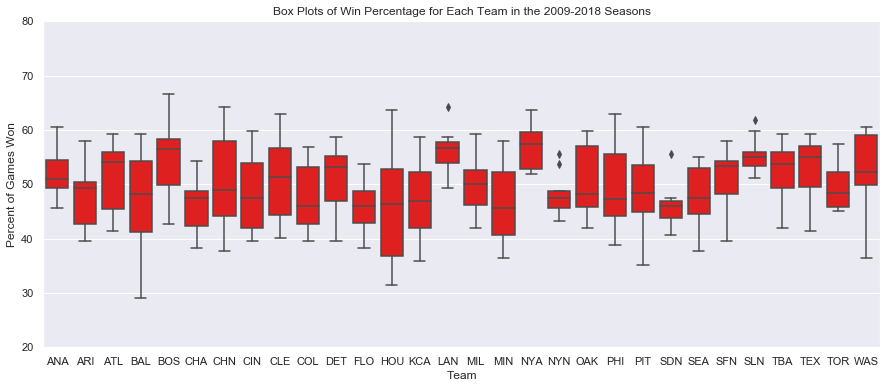

In [18]:
plt.figure(figsize=(15,6))
ax = sns.boxplot(x='HomeTeam', y='pc_won', data=total_wins_year, palette=['red'])
plt.xlabel('Team')
plt.ylabel('Percent of Games Won')
plt.ylim([20,80])
plt.title('Box Plots of Win Percentage for Each Team in the 2009-2018 Seasons')

These boxplots show us that teams such as the Saint Louis Cardinals (SLN) and the New York Yankees (NYA) have been consistently above-average teams, winning over 50% of their games in each season from 2009-2018.  We see that teams such as the San Diego Padres and the New York Mets (NYN) have finished with losing records fairly consitently over the last 10 years.

The Boston Red Sox have the maximum win percentage (66.67) of any team in any of the 10 seasons.  This occured in 2018 when they won 108 of 162 regular season games.  The Baltimore Orioles have the lowest season win percentage of any team.  This also occured in 2018 when they only won 47 of 162 games.

Teams with tall box plots, such as the Houston Astros (HOU) and the Baltimore Orioles have not been very consistent in the 2009-2018 seasons. It may be interesting to look at time series plots of the records of these two teams to see if they have been consistenly improving, worsening, or if there is no pattern.

Text(0.5, 1.0, 'Time Series Plot of Win Percentage')

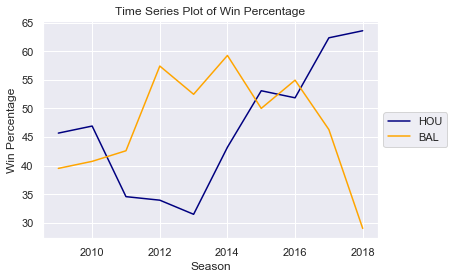

In [19]:
total_wins_year.reset_index(inplace=True)
hou = total_wins_year[total_wins_year['HomeTeam']=='HOU']
bal = total_wins_year[total_wins_year['HomeTeam']=='BAL']
plt.plot(hou['Date'],hou['pc_won'], color = 'navy', label = 'HOU')
plt.plot(bal['Date'],bal['pc_won'], color = 'orange', label = 'BAL')
plt.legend(loc='center left', title=None, bbox_to_anchor = (1,0.5))
plt.xlabel('Season')
plt.ylabel('Win Percentage')
plt.title('Time Series Plot of Win Percentage')


The Houston Astros had their worst season in 2013 and have been improving since (although there was a minor dip in 2016).  The Baltimore Orioles had their best season in 2014 and have been trending downwards since than (other than the 2016 season when their record improved). 

## Question 3: What happens when American League teams play National League teams?
Since the National League and the American League have slightly different rules it may be interesting to see if the home team has the advantage in interleague games. 

In [20]:
ALvsNL = gamelogs[gamelogs['HomeTeamLeague'] != gamelogs['VisitingTeamLeague']]

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 1.0, 'InterLeague Games with HomeTeamLeague = NL')

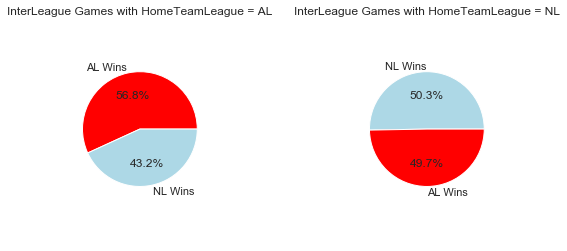

In [21]:

fig = plt.figure()
# First plot
fig.add_subplot(1,2,1)
plt.axis('equal')
#plt.subplots_adjust(top=0.2, wspace=0.2)

homeAL = ALvsNL[ALvsNL['HomeTeamLeague']=='AL']
fig.add_subplot(1,2,1)
plt.axis('equal')
plt.pie(homeAL['HomeWin'].value_counts(), colors = ['red', 'lightblue'], labels = ['AL Wins','NL Wins'], autopct='%1.1f%%', radius=3)
plt.subplots_adjust(wspace=5)
plt.title('InterLeague Games with HomeTeamLeague = AL')

homeNL = ALvsNL[ALvsNL['HomeTeamLeague']=='NL']
fig.add_subplot(1,2,2)
plt.axis('equal')
plt.pie(homeNL['HomeWin'].value_counts(), colors = ['lightblue', 'red'], labels = ['NL Wins','AL Wins'], autopct='%1.1f%%', radius=3)
plt.title('InterLeague Games with HomeTeamLeague = NL')


It seems that the American League may have an advantage when playing at home against National League teams (under American League rules), given that in the 2009-2018 season they won 56.84% of they're home games against National League teams.


## Question 3: Is there a correlation between a teams record and their home field attendance?

In [22]:
gamelogs_melt = pd.melt(gamelogs, id_vars = ['Date', 'HomeWin','Attendance'], value_vars = ['HomeTeam','VisitingTeam'], value_name = 'Team').sort_values(['Team','Date'])
gamelogs_melt.head(10)

,Date,HomeWin,Attendance,variable,Team
7,2009-04-06,1,43220.0,HomeTeam,ANA
19,2009-04-07,0,43396.0,HomeTeam,ANA
32,2009-04-08,0,43283.0,HomeTeam,ANA
56,2009-04-10,1,41385.0,HomeTeam,ANA
71,2009-04-11,0,40163.0,HomeTeam,ANA
86,2009-04-12,1,38076.0,HomeTeam,ANA
24410,2009-04-14,1,45958.0,VisitingTeam,ANA
24424,2009-04-15,1,18516.0,VisitingTeam,ANA
24435,2009-04-16,0,18528.0,VisitingTeam,ANA
24446,2009-04-17,1,24168.0,VisitingTeam,ANA


In [23]:
def win_or_loss(game):
    if (game['HomeWin'] == 1 and game['variable'] == 'HomeTeam') or (game['HomeWin'] == 0 and game['variable'] == 'VisitingTeam'):
        win = 1; loss = 0
    else: 
        win = 0; loss = 1
    return win, loss            

In [24]:
gamelogs_melt['Win']= gamelogs_melt.apply(lambda game: win_or_loss(game)[0], axis=1)
gamelogs_melt['Loss']= gamelogs_melt.apply(lambda game: win_or_loss(game)[1], axis=1)
gamelogs_melt.tail()

,Date,HomeWin,Attendance,variable,Team,Win,Loss
24219,2018-09-25,1,26483.0,HomeTeam,WAS,1,0
24233,2018-09-26,1,28680.0,HomeTeam,WAS,1,0
48549,2018-09-28,1,48089.0,VisitingTeam,WAS,0,1
48565,2018-09-29,0,47781.0,VisitingTeam,WAS,1,0
48581,2018-09-30,1,47833.0,VisitingTeam,WAS,0,1


In [25]:
def record(df, col):
    """Calculate a team's record at the end of the game"""
    total = df.groupby(['Team','Year'])[col].apply(lambda game : game.cumsum())
    return total

In [26]:
gamelogs_melt['Year'] = gamelogs_melt['Date'].dt.year
gamelogs_melt['WinRecord'] = record(gamelogs_melt, 'Win')
gamelogs_melt['LossRecord'] = record(gamelogs_melt, 'Loss')
gamelogs_melt.head()

,Date,HomeWin,Attendance,variable,Team,Win,Loss,Year,WinRecord,LossRecord
7,2009-04-06,1,43220.0,HomeTeam,ANA,1,0,2009,1,0
19,2009-04-07,0,43396.0,HomeTeam,ANA,0,1,2009,1,1
32,2009-04-08,0,43283.0,HomeTeam,ANA,0,1,2009,1,2
56,2009-04-10,1,41385.0,HomeTeam,ANA,1,0,2009,2,2
71,2009-04-11,0,40163.0,HomeTeam,ANA,0,1,2009,2,3


In [27]:
gamelogs_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48596 entries, 7 to 48581
Data columns (total 10 columns):
Date          48596 non-null datetime64[ns]
HomeWin       48596 non-null int64
Attendance    48596 non-null float64
variable      48596 non-null object
Team          48596 non-null object
Win           48596 non-null int64
Loss          48596 non-null int64
Year          48596 non-null int64
WinRecord     48596 non-null int64
LossRecord    48596 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(6), object(2)
memory usage: 4.1+ MB


In [28]:
home_games = gamelogs_melt[gamelogs_melt['variable'] == 'HomeTeam']

In [29]:
home_team_avg_attend = home_games.groupby(['Team','Year'])['Attendance'].apply(np.mean)
total_wins = gamelogs_melt.groupby(['Team','Year'])['WinRecord'].last()
attendance_and_wins = pd.concat([home_team_avg_attend, total_wins], axis=1)

In [30]:
attendance_and_wins.reset_index(level=['Team', 'Year'], inplace=True)


/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


r2: 0.21


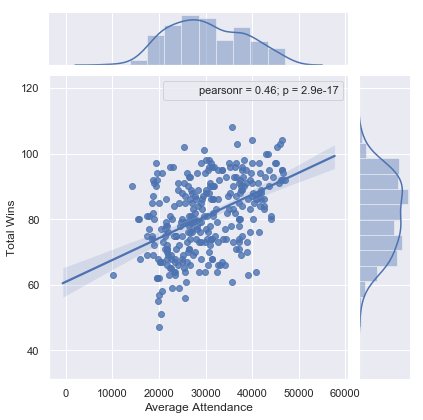

In [31]:
jplot = sns.jointplot(x = 'Attendance', y='WinRecord', data = attendance_and_wins, kind = 'reg')
corr = np.corrcoef(attendance_and_wins['Attendance'], attendance_and_wins['WinRecord'])[0,1]
jplot.annotate(stats.pearsonr)
r2 = str(round(corr ** 2,2))
#jplot.annotate(rsquare, template='{stat}: {val:.2f}', stat='$R^2$', loc='upper left', fontsize=12)
plt.xlabel('Average Attendance')
plt.ylabel('Total Wins')
print('r2: ' + r2)

The above plot shows us that the average attendance and total number of wins in a season has a moderate positive correlation.   There is a statistically significant correlation. It seems that the attendance increases, so does the number of wins.  The $R^2$ value of 0.21 tells us that only 21% of the variation in total wins is explained by the attendance.

## Question 4: Has attendance decreased over time?

Text(0, 0.5, 'Attendance')

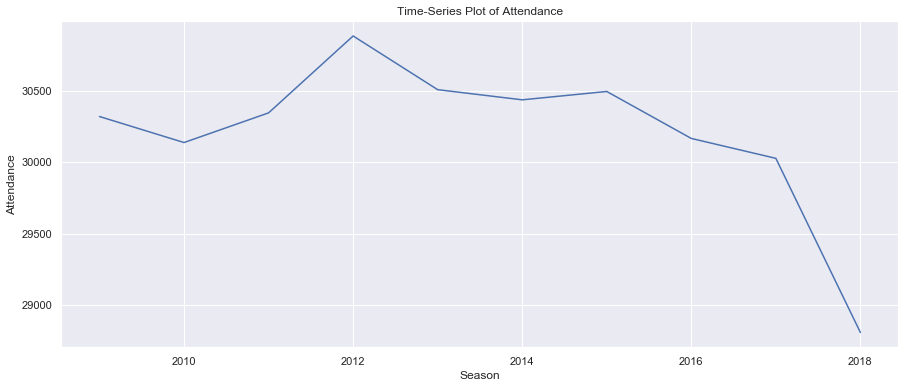

In [32]:
yearlyAtt = gamelogs.groupby(gamelogs['Date'].dt.year)['Attendance'].mean()
plt.figure(figsize=(15,6))
plt.plot(yearlyAtt)
plt.title('Time-Series Plot of Attendance')
plt.xlabel('Season')
plt.ylabel('Attendance')

From this graph it appear that attendance fluctuates a lot through the season, and it seems that attendance dropped in the 2018 season.

## Question 5: Does the visiting team make more errors than the home team?

Text(0.5, 1.0, 'Violin Plots of Errors Made by Home and Away Teams')

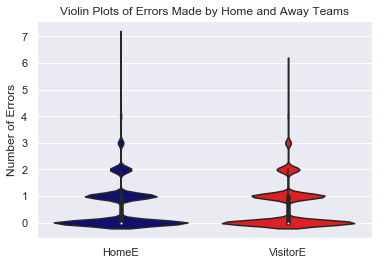

In [33]:
sns.violinplot(data = gamelogs.loc[:,['HomeE','VisitorE']], palette=['navy','red'])
plt.ylabel('Number of Errors')
plt.title('Violin Plots of Errors Made by Home and Away Teams')

In [34]:
gamelogs.loc[:,['HomeE','VisitorE']].describe()

,HomeE,VisitorE
count,24298.000000,24298.000000
mean,0.590419,0.596716
std,0.807317,0.798897
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,7.000000,6.000000


From the violin plots and the summary statistics, it seems that the number of errors does not differ very much for home team and away teams.  The biggest disc appears at errors = 0 for both the home team and visiting team and as the number of errors increases the size of the discs decrease.  It is clear that the players do not make many errors.

Text(0.5, 1.0, 'Avg. Number of Errors per Day')

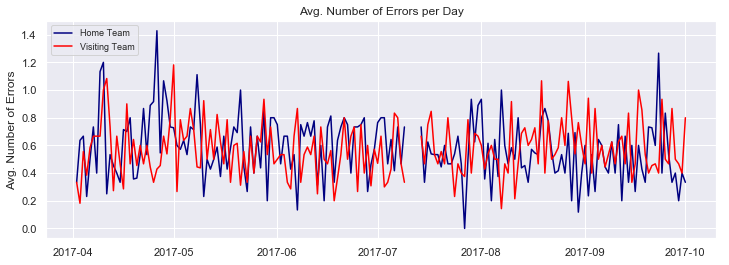

In [35]:
gamelogs.set_index('Date', inplace=True)
plt.figure(figsize = (12,4))
resampledHomeErrors = gamelogs['HomeE'].resample('D').mean()
resampledRoadErrors = gamelogs['VisitorE'].resample('D').mean()
plt.plot(resampledHomeErrors['2017'], label = 'Home Team', color = 'navy')
plt.plot(resampledRoadErrors['2017'], label = 'Visiting Team', color = 'red')
plt.legend(loc = 'upper left', fontsize = 9)
plt.ylabel('Avg. Number of Errors')
plt.title('Avg. Number of Errors per Day')

We see that there is a lot of overlap in the time series plot for average number of errors made by home teams and average number of errors made by the visiting team in day in the 2017 season.  This is similar for all other seasons too.  

## Question 6. Do starting pitchers on winning teams pitch more innings than starting pitchers on losing teams?

In [36]:
winnersIP = []
losersIP = []
for i, game in gamelogs.iterrows():
    if game['HomeWin'] == 1:
        winnerIP = game['IP_H']
        loserIP = game['IP_V']
    else:
        winnerIP = game['IP_V']
        loserIP = game['IP_H']
    winnersIP.append(winnerIP)
    losersIP.append(loserIP)
    

Text(0, 0.5, 'Frequency')

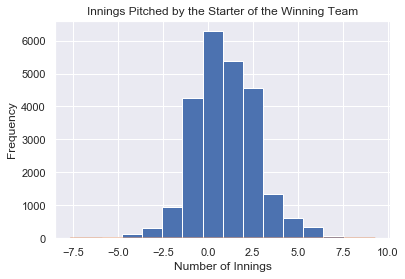

In [37]:
inningsbyStarter = pd.DataFrame({'winnersIP': winnersIP, 'losersIP': losersIP})
inningsbyStarter['diff'] = inningsbyStarter['winnersIP']-inningsbyStarter['losersIP']

plt.hist(inningsbyStarter['diff'], bins = 14)
sns.distplot(inningsbyStarter['diff'])
plt.title('Innings Pitched by the Starter of the Winning Team')
plt.xlabel('Number of Innings')
plt.ylabel('Frequency')


In [38]:
inningsbyStarter['diff'].describe()

count    24298.000000
mean         0.923684
std          1.761652
min         -7.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          8.666667
Name: diff, dtype: float64

We see that in 75% of games in the 2009-2018 seasons, the starting pitcher on the team who won pitched for as many innings or more innings than the starting pitcher of the losing team.

## 7. How often do teams with the higher average On Base Percentage win the game?
OBP = (Hits + Walks + Hit by Pitch) / (At Bats + Walks + Hit by Pitch + Sacrifice Flies)


In [39]:
gamelogs['HomeOBP'] = (gamelogs['HomeH'] + gamelogs['HomeBB'] + gamelogs['HomeHBP'])/(gamelogs['HomeAB']+gamelogs['HomeBB']+gamelogs['HomeHBP']+gamelogs['HomeSF'])
gamelogs['VisitOBP'] = (gamelogs['VisitorH']+gamelogs['VisitorBB'] + gamelogs['VisitorHBP'])/(gamelogs['VisitorAB']+gamelogs['VisitorBB']+gamelogs['VisitorHBP']+gamelogs['VisitorSF'])

In [40]:
gamelogs.reset_index(inplace=True)
OBP_melt = melt_gamelogs(['HomeOBP','VisitOBP'])


In [41]:
def relavent_team_stat(df, home_col, visit_col):
    stats = []
    for i, row in df.iterrows():
        if row['variable'] == 'HomeTeam':
            stat = row[home_col]
        else:
            stat = row[visit_col]
        stats.append(stat)
    return stats

def calculate_teamavg(game):
    avg = game.expanding(5).mean().shift()
    return avg

#total = df.groupby(['Team','Year'])[col].apply(lambda game : game.cumsum())

In [42]:
OBP_melt = OBP_melt.sort_values('Date')
OBP_melt['OBP'] = relavent_team_stat(OBP_melt, 'HomeOBP', 'VisitOBP')

In [43]:
OBP_melt['AvgOBP'] = OBP_melt.groupby(['Team', OBP_melt['Date'].dt.year])['OBP'].apply(calculate_teamavg)
OBP_melt['AvgOBP'] = OBP_melt.groupby('Team')['AvgOBP'].fillna(method='ffill') #so first five games of season uses previous seasons stats

In [44]:
#make sure it worked correctly
bos = OBP_melt[OBP_melt['Team']=='BOS']
print(bos[bos['Date'].dt.year == 2009].AvgOBP.tail())
bos[bos['Date'].dt.year == 2010].head(10)

2367    0.342811
2380    0.341828
2393    0.342326
2408    0.342654
2423    0.343166
Name: AvgOBP, dtype: float64


,Date,HomeWin,DoubleHeader,HomeOBP,VisitOBP,variable,Team,OBP,AvgOBP
2430,2010-04-04,1,0,0.410256,0.418605,HomeTeam,BOS,0.410256,0.343166
2445,2010-04-06,0,0,0.289474,0.372093,HomeTeam,BOS,0.289474,0.343166
2452,2010-04-07,0,0,0.282051,0.300000,HomeTeam,BOS,0.282051,0.343166
26779,2010-04-09,1,0,0.312500,0.351351,VisitingTeam,BOS,0.351351,0.343166
26794,2010-04-10,0,0,0.285714,0.350000,VisitingTeam,BOS,0.350000,0.343166
26809,2010-04-11,0,0,0.342105,0.418605,VisitingTeam,BOS,0.418605,0.336627
26823,2010-04-12,1,0,0.400000,0.242424,VisitingTeam,BOS,0.242424,0.350290
26844,2010-04-14,0,0,0.390244,0.380952,VisitingTeam,BOS,0.380952,0.334880
26857,2010-04-15,1,0,0.404762,0.257143,VisitingTeam,BOS,0.257143,0.340639
2570,2010-04-16,0,0,0.239130,0.181818,HomeTeam,BOS,0.239130,0.331362


In [45]:
OBP_melt = OBP_melt[['Date','DoubleHeader','Team','AvgOBP']]
gamelogs2 = merge_twice(gamelogs, OBP_melt, 'HomeTeam', 'VisitingTeam', 'Team')

In [46]:
gamelogs2.shape

(24298, 212)

In [47]:
#Check that the only null entries are games in 2009 where it is either the home team's 
# or the visiting team's (or both) first 5 games of the season
null_OBP = gamelogs2[gamelogs2['AvgOBP_H'].isnull()|gamelogs2['AvgOBP_V'].isnull()]
print(null_OBP.shape)
null_OBP[(null_OBP.Date.dt.year != 2009) | ((null_OBP['HomeTeamGameNumber'] > 5) & (null_OBP['VisitingTeamGameNumber'] >5))]

(79, 212)


,Date,DoubleHeader,DayOfWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,VisitorRunsScored,...,BK_V,WP_V,PitchAbbrev_V,HomeWin,HomeOBP,VisitOBP,Team_H,AvgOBP_H,Team_V,AvgOBP_V


In [48]:
outfile = open('gamelogs2', 'wb')
pickle.dump(gamelogs2, outfile)
outfile.close()

In [49]:
winnersOBP = []
losersOBP = []
for i, game in gamelogs2.iterrows():
    if game['HomeWin'] == 1:
        winnerOBP = game['AvgOBP_H']
        loserOBP = game['AvgOBP_V']
    else:
        winnerOBP = game['AvgOBP_V']
        loserOBP = game['AvgOBP_H']
    winnersOBP.append(winnerOBP)
    losersOBP.append(loserOBP)

In [50]:
df_OBPs = pd.DataFrame({'winnersOBP': winnersOBP, 'losersOBP':losersOBP})

In [51]:
df_OBPs['WinnerHigher'] = df_OBPs['winnersOBP'] > df_OBPs['losersOBP']

In [52]:
df_OBPs.dropna(axis=0, inplace=True)
df_OBPs.head()
df_OBPs['WinnerHigher'].value_counts()

True     12791
False    11428
Name: WinnerHigher, dtype: int64

Text(0.5, 1.0, 'Did the team that won have a higher Average OBP before the game?')

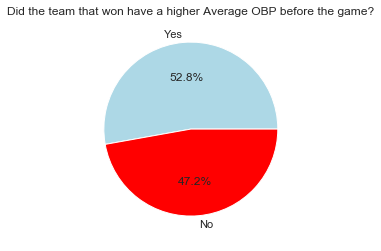

In [53]:
plt.pie(df_OBPs['WinnerHigher'].value_counts(), colors = ['lightblue', 'red'], labels = ['Yes','No'], autopct='%1.1f%%')
plt.title('Did the team that won have a higher Average OBP before the game?')

Based on this pie chart, we see that in 52.8% of games, the team that had the higher averagre on-base percentage entering the game, won the game. 

Text(0, 0.5, 'Frequency')

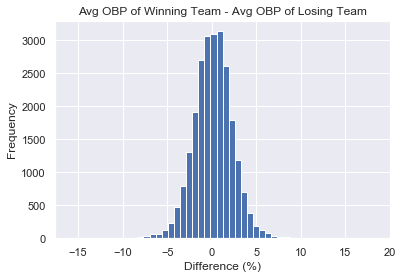

In [54]:
df_OBPs['diff'] = 100 * (df_OBPs['winnersOBP'] - df_OBPs['losersOBP'])
plt.hist(df_OBPs['diff'], bins = 50)
plt.title('Avg OBP of Winning Team - Avg OBP of Losing Team')
plt.xlabel('Difference (%)')
plt.ylabel('Frequency')

In [55]:
df_OBPs['diff'].describe()

count    24219.000000
mean         0.133151
std          2.217600
min        -15.856221
25%         -1.215020
50%          0.158608
75%          1.504895
max         18.324232
Name: diff, dtype: float64

In the histogram, games with a difference > 0 represent games in which the winner had a higher average OBP coming into the game, while games with a difference < 0 represent games in which the winner had a lower OBP before the game. In 50% of the games the winning team has a average OBP that is at least 0.15% higher than the losing team, but 0.15% is not large at all.  In 25% of games the team that won had an average OBP that was 1.215% lower than the losing team.  We see from the pie chart and histogram that there are many games (47.2%) where the team with the lower OBP won. 

Text(0, 0.5, 'Frequency')

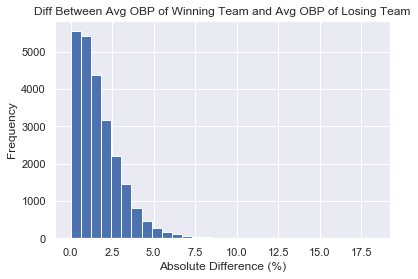

In [56]:
df_OBPs['absolute_diff'] = abs(df_OBPs['diff'])
plt.hist(df_OBPs['absolute_diff'], bins = 30)
plt.title('Diff Between Avg OBP of Winning Team and Avg OBP of Losing Team')
plt.xlabel('Absolute Difference (%)')
plt.ylabel('Frequency')

In [57]:
df_OBPs['absolute_diff'].describe()

count    24219.000000
mean         1.698396
std          1.432065
min          0.000031
25%          0.663566
50%          1.375882
75%          2.368616
max         18.324232
Name: absolute_diff, dtype: float64

We see that the absolute difference in average OBPs between opponents has a maximum value of 18.32%, but that in 75% of games the difference in OBPs is 2.369% or less, so in most hames the teams are fairly evelny matched in terms of on-base percentage.  As the difference in average OBPs gets higher, the frequency decreases.  It makes sence that the average OBPs are typically pretty similar, since they are all professional baseball players.

# Conclusions

None of the findings from this exploratory data analysis were particularly surprising.

It seems that the home team does have an advantage win more games than the visiting teams.  The home team won 53.7% of games in the 2009-2018 seasons.  In addition, all 30 teams has have a better home record than they do away record.

It also appears that as the average attendance increases, so does the number of games won.  It could be that the large crowds help the home team perform better, or it could be that there is higher attendance because the team is winning more, so may be more exciting to watch.

It also seems that baseball attendance dropped in 2018.

The number of errors made per team per game is very low, which is a good sign since it is professional baseball, and there does not seem to be a big difference between the number of errors made by the home team and the visiting team.

Starting pitchers on the winning team do seem to pitch more innings than the starting pitcher on the losing teams.  This makes sense because if the starting pitcher is performing poorly, they will be taken out of the game earlier.  

In 52.8% of games in the 2009-2018 seasons the team with the higher average on-base percentage won the game.  This is not too surprising because in most games the average on-base percentage of the opponemts are not very far apart, and there are many factors that go into winning an individual game. 
